# Uwaga

Hash ostatniego commita w repo z zadaniami gdy pobrałem tekst zadań: `e3d6681`

Link do ostatniego commita: [link](https://github.com/apohllo/nlp/commit/e3d6681744adf3dd9025ce5386ab622a30c7e42f)

In [2]:
import numpy as np
from datasets import load_dataset
import pandas as pd

In [ ]:
queries_df = load_dataset("clarin-knext/fiqa-pl", "queries")["queries"].to_pandas()
corpus_df = load_dataset("clarin-knext/fiqa-pl", "corpus")["corpus"].to_pandas()
dataset = load_dataset("clarin-knext/fiqa-pl-qrels")
train_df = dataset["train"].to_pandas()
validation_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()
relevance_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)

queries_df._id = queries_df._id.astype(int)
corpus_df._id = corpus_df._id.astype(int)
relevance_df = relevance_df.astype(int)

## Zadania 1, 2, 3 i 4

*Importy, ładowanie danych z lab 1*

*Use SpaCy tokenizer API to tokenize the text in the documents.* 

*Compute frequency list for each of the processed files.*

*Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words appearing in the corpus.*


In [5]:
import spacy
nlp = spacy.load("pl_core_news_sm")

In [6]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

Wyznaczamy globalny `frequency_list` 

In [8]:
dictionary_counts = {}
for _, row in corpus_df.iterrows():
  text = row.text
  for token in tokenizer(text):
    dictionary_counts[token.text] = dictionary_counts.get(token.text, 0) + 1
len(dictionary_counts)

409339

Popatrzmy jak to wygląda w środku

[('w', 156232), ('i', 120930), ('na', 113615), ('nie', 107751), ('z', 92365), ('że', 89781), ('jest', 86200), ('to', 82683), ('się', 73508), ('do', 65537), ('o', 37026), ('a', 35507), ('ale', 33693), ('są', 33559), ('za', 31405), ('lub', 29762), ('jak', 29668), ('aby', 28939), ('od', 28909), ('jeśli', 27219)]


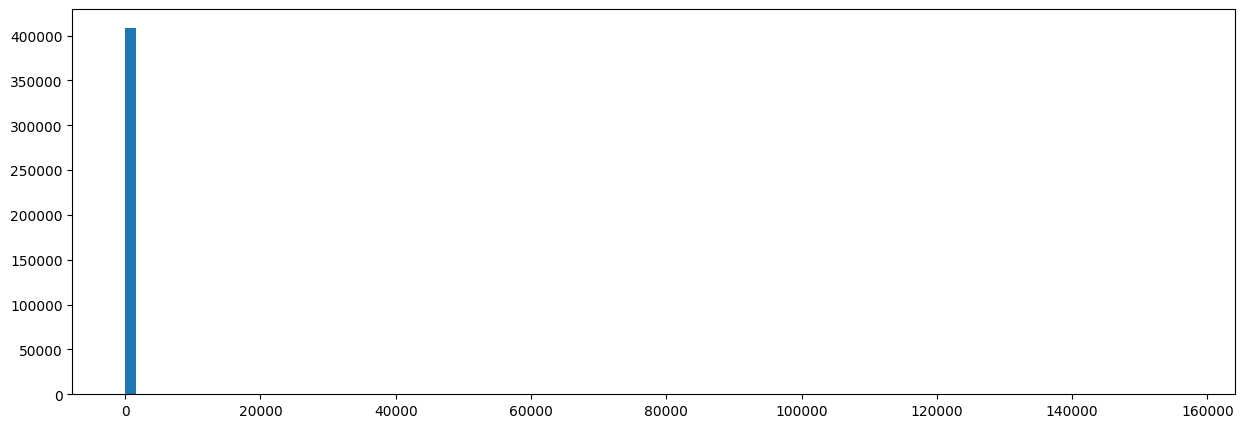

In [41]:
import matplotlib.pyplot as plt

dictionary_counts_list = list(dictionary_counts.items())
dictionary_counts_list.sort(key=lambda tup: tup[1], reverse=True)
print(dictionary_counts_list[:20])
del dictionary_counts_list

values = dictionary_counts.values()

plt.figure(figsize=(15, 5))
plt.hist(values, bins=100)
plt.show()

Widzimy, że najbardziej powtarzające się słowa to spójniki / krótkie (to spodziewane).

Na wykresie (oś Y - liczba słów z daną liczbą powtórzeń, oś X - liczba powtórzeń) --> bardzo dużo wyrazów występuje bardzo małą liczbę razy.

## Zadanie 5

*Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.*


In [9]:
from random import randint, choice
from string import ascii_lowercase

letters = ascii_lowercase + "ąćęłńóśżź"

Funkcja modyfikująca query

In [10]:
def add_distortion(query):
  tokens = tokenizer(query)
  token_idx = randint(0, len(tokens) - 1)
  token = tokens[token_idx]
  idx = token.idx
  letter_idx = randint(0, len(token) - 1)
  new_letter = old_letter = token.text[letter_idx]
  while new_letter == old_letter:
    new_letter = choice(letters)
  new_query = query[:idx + letter_idx] + new_letter + query[idx + letter_idx + 1:]
  return new_query

In [11]:
add_distortion("Kot bardzo lubi gonić psa po całym ogrodzie.")

'Kot bardzo lubf gonić psa po całym ogrodzie.'

Modyfikujemy query

In [12]:
queries_df["text_distortion"] = queries_df.text.apply(add_distortion)

ESa postawiłem lokalnie, setup jak w lab 2, z tym, że tym razem korzystam bardziej z API niż z Kabana

In [19]:
from elasticsearch_dsl import analyzer, connections, Index, Document, Text, Search
from elasticsearch.helpers import bulk
from elasticsearch import Elasticsearch

connections.create_connection(hosts="http://localhost:9200", verify_certs=False)
es = Elasticsearch(["localhost:9200"])

In [20]:
base_analyzer = analyzer('base analyzer',
    tokenizer="standard",
    filter=['lowercase', 'morfologik_stem', 'lowercase']
)


class Article(Document):
  body = Text(analyzer=base_analyzer)

  class Index:
    name = "corpus"

Article.init()

Wgrywamy dane

In [21]:
articles = []
for _, row in corpus_df.iterrows():
  art = Article(meta={'id': row._id}, body=row.text, ).to_dict(include_meta=True)
  articles.append(art)
bulk(es, articles)

(57638, [])

## Zadanie 6

*Compute nDCG@10 for the distorted queris, using the same approach as in lab 2. This result will be the baseline for the other methods.*

In [22]:
from tqdm import tqdm

def calculate_ndcg_baseline(k=10):
  scores_list = 1 / np.log2(np.arange(2, 2 + k))
  score_cum = 0
  for _, query_row in tqdm(queries_df.iterrows()):
    query_relevance = relevance_df[relevance_df['query-id'] == query_row._id]
    num_relevance = np.clip(len(query_relevance), a_min=None, a_max=5)
    q = query_row.text_distortion

    body = {"query": {"match": {"body": {"query": q}}}}
    response = es.search(index="corpus", body=body, size=k)

    mask = np.full(k, False)
    for ix, hit in enumerate(response["hits"]["hits"]):
      qid = int(hit["_id"])
      if np.sum(query_relevance["corpus-id"] == qid):
        mask[ix] = True
    score = np.sum(scores_list[mask]) / np.sum(scores_list[:num_relevance])
    score_cum += score
  return score_cum / len(queries_df)

In [23]:
calculate_ndcg_baseline()

6648it [01:17, 85.38it/s] 


0.18488198035803477

# Zadania 7, 8, 9

*Install Morfeusz (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary. Only these words should be corected in the next step.*

*Use Levenshtein distance and the frequency list, to determine the most probable correction of the words in the queries that were identified as invalid. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)*

*Compute nDCG@10 for your implementation of the spelling correction method.*

In [25]:
import morfeusz2
morf = morfeusz2.Morfeusz(whitespace=morfeusz2.KEEP_WHITESPACES)

Generalnie pałujemy: podejście jest takie, żeby generować wszystkie słowa w odległości edycyjnej 1 i 2 i na podstawie `frequency_list` wybierać te które są dla nas ok. To nie ma prawa działać szybko.

In [26]:
def generate_close_words_1(word):
  yield word
  for i in range(len(word)):
    yield word[:i] + word[i + 1:] # remove i-th character
    for letter in letters + "-_":
      yield word[:i] + letter + word[i:] # add letter before i-th character
      yield word[:i] + letter + word[i + 1:] # replace letter with i-th character
  for letter in letters + "-_!.,?;:":
    yield word + letter

def generate_close_words_2(word):
  yield word
  for word1 in generate_close_words_1(word):
    if word1 == word:
      continue
    yield word1
    for word2 in generate_close_words_1(word1):
      if word2 == word:
        continue
      yield word2

def get_correction(word, generator):
  best_num = 0
  correction = None
  for word_g in generator(word):
    num = dictionary_counts.get(word_g, 0)  # <-- tutaj korzystamy z `frequency_list` do wyznaczania korekcji
    if num > best_num:
      best_num = num
      correction = word_g
  return correction

def correct_word(word, mode="default"): # mode = (default|dis1|dis2)
  if mode == "dis2":
    correction = get_correction(word, generate_close_words_2)
  else:
    correction = get_correction(word, generate_close_words_1)
  if correction is None:
    if mode == "default":
      correction = get_correction(word, generate_close_words_2)
      if correction is None:
        return word
    else:
      return word
  return correction


def calculate_ndcg_morfeusz(k=10, mode="default"):
  scores_list = 1 / np.log2(np.arange(2, 2 + k))
  score_cum = 0
  for _, query_row in tqdm(queries_df.iterrows()):
    query_relevance = relevance_df[relevance_df['query-id'] == query_row._id]
    num_relevance = np.clip(len(query_relevance), a_min=None, a_max=5)
    q = query_row.text_distortion
    ### MORFEUSZ ###
    unknown = []
    words = []
    for ix, _, analysis in morf.analyse(q):
      if len(words) > ix:
        continue
      words.append(analysis[0])
      if analysis[2] == "ign":
        unknown.append((ix, analysis[0]))

    for ix, word in unknown:
      new_word = correct_word(word, mode)
      words[ix] = new_word

    q = "".join(words)
    #######
    body = {"query": {"match": {"body": {"query": q}}}}
    response = es.search(index="corpus", body=body, size=k)

    mask = np.full(k, False)
    for ix, hit in enumerate(response["hits"]["hits"]):
      qid = int(hit["_id"])
      if np.sum(query_relevance["corpus-id"] == qid):
        mask[ix] = True
    score = np.sum(scores_list[mask]) / np.sum(scores_list[:num_relevance])
    score_cum += score
  return score_cum / len(queries_df)

In [27]:
calculate_ndcg_morfeusz(mode="default")

6648it [01:57, 56.52it/s]


0.19531668287814827

In [28]:
calculate_ndcg_morfeusz(mode="dis1")

6648it [00:58, 113.94it/s]


0.1953307497111566

In [29]:
calculate_ndcg_morfeusz(mode="dis2")

6648it [25:37,  4.32it/s]


0.18033608925100297

W trybie domyślnym i z odgległością edycyjną równą 1 liczy się to ~ 1 min. Ciężko powiedzieć czy to dobrze bez innej referencyjnej implementacji pythonowej.
Widzimy poprawię o ~ 1 p.p.

Przy odległości edycyjnej 2, złożoność eksploduje (czas liczenia ok. 25 min.) i można powiedzieć, że jest to nieużywalne + wynik jest pogorszony.

In [42]:
def fix_query(q, mode="default"):
  unknown = []
  words = []
  for ix, _, analysis in morf.analyse(q):
    if len(words) > ix:
      continue
    words.append(analysis[0])
    if analysis[2] == "ign":
      unknown.append((ix, analysis[0]))

  for ix, word in unknown:
    new_word = correct_word(word, mode)
    words[ix] = new_word

  return "".join(words)

In [44]:
idx = 0
print(queries_df.iloc[idx].text_distortion)
print(fix_query(queries_df.iloc[idx].text_distortion))

ziełda w USA
giełda w USA


In [46]:
idx = 25
print(queries_df.iloc[idx].text_distortion)
print(fix_query(queries_df.iloc[idx].text_distortion))

Opcje inweętycyjne
Opcje inwestycyjne


In [47]:
idx = 100
print(queries_df.iloc[idx].text_distortion)
print(fix_query(queries_df.iloc[idx].text_distortion))

Chym jest presja kupna?
Czym jest presja kupna?


^-- Wygląda ok

## Zadanie 10
 
*Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.*

In [ ]:
queries_df["size"] = queries_df.text_distortion.apply(len)
queries_df.sort_values(by=["size"], inplace=True)

def calculate_ndcg_fuzzy_search(k=10, fuzziness="AUTO"):
  scores_list = 1 / np.log2(np.arange(2, 2 + k))
  score_cum = 0
  not_too_complex_count = 0
  max_size = 0
  for _, query_row in tqdm(queries_df.iterrows()):
    if str(fuzziness) == "2" and query_row["size"] > 116:
      break
    query_relevance = relevance_df[relevance_df['query-id'] == query_row._id]
    num_relevance = np.clip(len(query_relevance), a_min=None, a_max=5)
    q = query_row.text_distortion

    body = {"query": {"fuzzy": {"body": {"value": q, "fuzziness": fuzziness}}}}
    try:
      response = es.search(index="corpus", body=body, size=k)
    except:
      continue
    not_too_complex_count += 1
    max_size = max(max_size, query_row["size"])

    mask = np.full(k, False)
    for ix, hit in enumerate(response["hits"]["hits"]):
      qid = int(hit["_id"])
      if np.sum(query_relevance["corpus-id"] == qid):
        mask[ix] = True
    score = np.sum(scores_list[mask]) / np.sum(scores_list[:num_relevance])
    score_cum += score
  too_complex_count = len(queries_df) - not_too_complex_count
  print(f"There are {too_complex_count} too complex queries ({100*too_complex_count/len(queries_df)})")
  print(f"Fuzziness - {fuzziness}, max_size - {max_size}")
  return score_cum / not_too_complex_count

  # ^--- Nie odpaliłem w końcu tego kodu, bo coś crashowało  ¯\_(ツ)_/¯ Sorry

In [32]:
body = {"query": {"match": {"body": {"query": "styczeń"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

329

In [33]:
body = {"query": {"match": {"body": {"query": "stwczeń"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

0

In [48]:
body = {"query": {"fuzzy": {"body": {"value": "styczeń", "fuzziness": "AUTO"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

362

In [49]:
body = {"query": {"fuzzy": {"body": {"value": "stwczeń", "fuzziness": "2"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

330

In [50]:
body = {"query": {"match": {"body": {"query": "styczeń został zasypany śniegiem"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

10000

In [51]:
body = {"query": {"match": {"body": {"query": "stwczeń został zasypany śniegiem"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

9839

In [52]:
body = {"query": {"fuzzy": {"body": {"value": "styczeń został zasypany śniegiem", "fuzziness": "AUTO"}}}}
response = es.search(index="corpus", body=body)
response["hits"]["total"]["value"]

0

Wygląda na to, że `fuzziness` słabo działa, jeżeli query jest nieco dłuższe